[Reference](https://medium.com/@eduardo.garcia.sv/if-you-dont-have-any-idea-how-to-create-a-stock-portfolio-this-will-help-you-99efc92cd4d5)

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 453 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
benchmark_ = ["^GSPC",]
portfolio_ = ['AAPL', 'MSFT', 'BRK-B', 'SPGI', 'BLK', 'IWDA.L', 'ULVR.L', 'SNOW', 'DTE.DE', 'UGAS.MI', 'EUNL.DE', 'EXXT.DE',  'GOOG', 'AMZN', 'SHOP', 'VOW.DE','MC.PA', 'DAX', 'ABNB', 'BX', 'COST', 'JNJ','NKE', 'PYPL', 'QCOM', 'WM']

start_date_ = "2017-01-01"
end_date_  = "2022-03-31"
number_of_scenarios = 10000

return_vector = []
risk_vector = []
distrib_vector = []

In [5]:
#Get Information from Benchmark and Portfolio
df = yf.download(benchmark_, start=start_date_, end=end_date_)
df2 = yf.download(portfolio_, start=start_date_, end=end_date_)

#Clean Rows with No Values on both Benchmark and Portfolio
df = df.dropna(axis=0)
df2 = df2.dropna(axis=0)

#Matching the Days
df = df[df.index.isin(df2.index)]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  26 of 26 completed


In [6]:
# Analysis of Benchmark
benchmark_vector = np.array(df['Close'])

#Create our Daily Returns
benchmark_vector = np.diff(benchmark_vector)/benchmark_vector[1:]

#Select or Final Return and Risk
benchmark_return = np.average(benchmark_vector)
benchmark_risk = np.std(benchmark_vector)

#Add our Benchmark info to our lists
return_vector.append(benchmark_return)
risk_vector.append(benchmark_risk)

In [7]:
# Analysis of Portfolio
portfolio_vector = np.array(df2['Close'])

#Create a loop for the number of scenarios we want:

for i in range(number_of_scenarios):
    #Create a random distribution that sums 1 
    # and is split by the number of stocks in the portfolio
    random_distribution = np.random.dirichlet(np.ones(len(portfolio_)),size=1)
    distrib_vector.append(random_distribution)
    
    #Find the Closing Price for everyday of the portfolio
    portfolio_matmul = np.matmul(random_distribution,portfolio_vector.T)
    
    #Calculate the daily return
    portfolio_matmul = np.diff(portfolio_matmul)/portfolio_matmul[:,1:]
    
    #Select or Final Return and Risk
    portfolio_return = np.average(portfolio_matmul, axis=1)
    portfolio_risk = np.std(portfolio_matmul, axis=1)
    
    #Add our Benchmark info to our lists
    return_vector.append(portfolio_return[0])
    risk_vector.append(portfolio_risk[0])

In [8]:
#Create Risk Boundaries
delta_risk = 0.05
min_risk = np.min(risk_vector)
max_risk = risk_vector[0]*(1+delta_risk)
risk_gap = [min_risk, max_risk]

In [9]:
#Portofolio Return and Risk Couple
portfolio_array = np.column_stack((return_vector,risk_vector))[1:,]

In [10]:
# Rule to create the best portfolio
# If the criteria of minimum risk is satisfied then:
if np.where(((portfolio_array[:,1]<= max_risk)))[0].shape[0]>1:
    min_risk_portfolio = np.where(((portfolio_array[:,1]<= max_risk)))[0]
    best_portfolio_loc = portfolio_array[min_risk_portfolio]
    max_loc = np.argmax(best_portfolio_loc[:,0])
    best_portfolio = best_portfolio_loc[max_loc]

# If the criteria of minimum risk is not satisfied then:
else:
    min_risk_portfolio = np.where(((portfolio_array[:,1]== np.min(risk_vector[1:]))))[0]
    best_portfolio_loc = portfolio_array[min_risk_portfolio]
    max_loc = np.argmax(best_portfolio_loc[:,0])
    best_portfolio = best_portfolio_loc[max_loc]

[Text(0, 0, '-20.00%'),
 Text(0, 0, '-10.00%'),
 Text(0, 0, '0.00%'),
 Text(0, 0, '10.00%'),
 Text(0, 0, '20.00%'),
 Text(0, 0, '30.00%')]

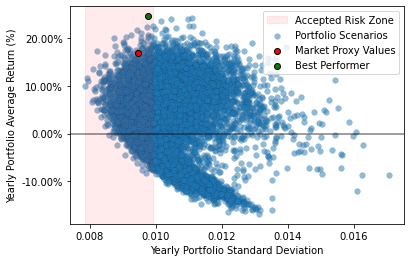

In [11]:
#Visual Representation
trade_days_per_year = 252
risk_gap = np.array(risk_gap)*trade_days_per_year
best_portfolio[0] = np.array(best_portfolio[0])*trade_days_per_year
x = np.array(risk_vector)
y = np.array(return_vector)*trade_days_per_year

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5, 
           linewidths=0.1,  
           edgecolors='black', 
           label='Portfolio Scenarios'
            )

ax.scatter(x[0], 
           y[0], 
           color='red', 
           linewidths=1,  
           edgecolors='black', 
           label='Market Proxy Values')
 
ax.scatter(best_portfolio[1], 
            best_portfolio[0], 
            color='green', 
            linewidths=1,  
            edgecolors='black', 
            label='Best Performer')

ax.axvspan(min_risk,
           max_risk, 
           color='red', 
           alpha=0.08,
           label='Accepted Risk Zone')

ax.set_ylabel("Yearly Portfolio Average Return (%)")
ax.set_xlabel("Yearly Portfolio Standard Deviation")

ax.axhline(y=0, color='black',alpha=0.5)

ax = plt.gca()
ax.legend(loc=0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
# ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])

In [12]:
#Output Table of Distributions
portfolio_loc = np.where((portfolio_array[:,0]==(best_portfolio[0]/trade_days_per_year))&(portfolio_array[:,1]==(best_portfolio[1])))[0][0]
best_distribution = distrib_vector[portfolio_loc][0].tolist()
d = {"Stock Name": portfolio_, "Stock % in Portfolio": best_distribution}
output = pd.DataFrame(d)
output = output.sort_values(by=["Stock % in Portfolio"],ascending=False)
output= output.style.format({"Stock % in Portfolio": "{:.2%}"})
output

,Stock Name,Stock % in Portfolio
15,VOW.DE,25.26%
4,BLK,15.75%
11,EXXT.DE,8.83%
24,QCOM,6.68%
6,ULVR.L,6.53%
21,JNJ,4.72%
25,WM,4.57%
13,AMZN,3.83%
18,ABNB,3.01%
5,IWDA.L,2.97%
